In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import joblib

2024-11-13 10:07:06.770003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 10:07:06.772779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 10:07:06.780495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731481626.793465  322288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731481626.797201  322288 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 10:07:06.811148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load Data Online
data = yf.download('TSLA', start='2015-01-01', end='2024-10-31')
data = data['Close']  # Focus on closing prices for forecasting

[*********************100%***********************]  1 of 1 completed


In [3]:
# Forecasting Horizon (6-12 months)
forecast_horizon = 252 

In [4]:
# Function to plot forecast with confidence intervals
def plot_forecast(data, predictions, confidence_intervals=None, title="Forecast"):
    plt.figure(figsize=(14, 7))
    plt.plot(data, label='Historical Data')
    plt.plot(predictions.index, predictions, label='Forecast', color='orange')
    if confidence_intervals is not None:
        plt.fill_between(predictions.index, 
                         confidence_intervals.iloc[:, 0], 
                         confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [15]:
# select model ARIMA SARIMA or LSTM
model_type = 'ARIMA' 

/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sa/Documents/GitHub/kifiya-week11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


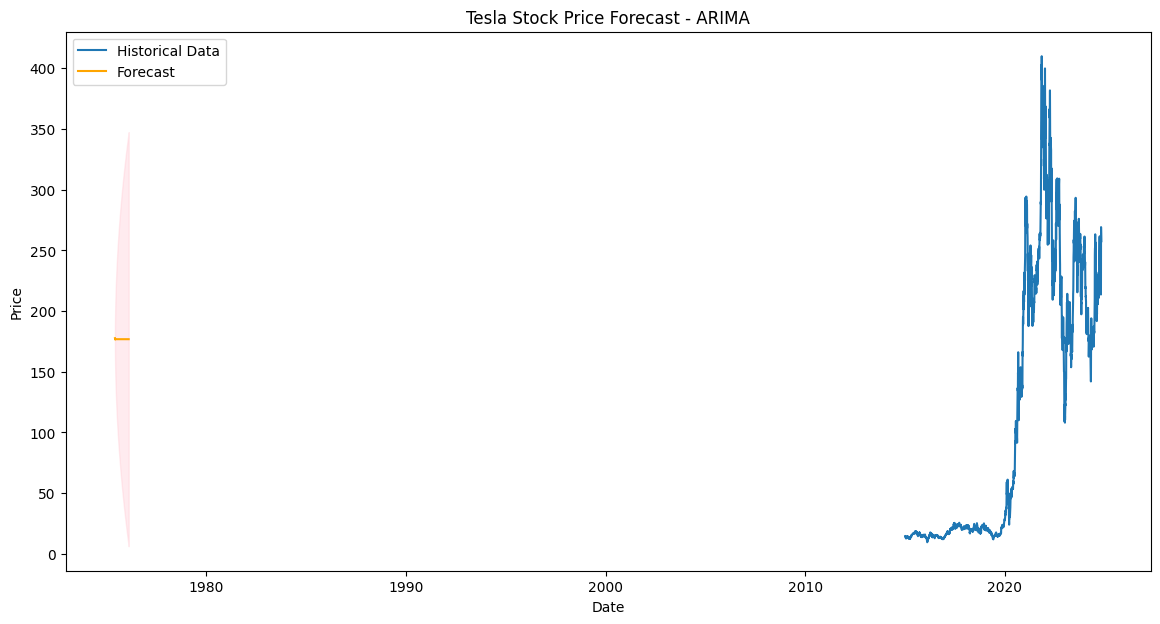

In [16]:
# 1. Load and Forecast with ARIMA Model
if model_type == 'ARIMA':
    arima_model = joblib.load("../models/arima_model.pkl")
    arima_forecast = arima_model.get_forecast(steps=forecast_horizon)
    arima_predictions = arima_forecast.predicted_mean
    confidence_intervals = arima_forecast.conf_int()
    plot_forecast(data, arima_predictions, confidence_intervals, "Tesla Stock Price Forecast - ARIMA")
# 2. Load and Forecast with SARIMA Model
elif model_type == 'SARIMA':
    sarima_model = joblib.load("../models/sarima_model.pkl")
    sarima_forecast = sarima_model.get_forecast(steps=forecast_horizon)
    sarima_predictions = sarima_forecast.predicted_mean
    confidence_intervals = sarima_forecast.conf_int()
    plot_forecast(data, sarima_predictions, confidence_intervals, "Tesla Stock Price Forecast - SARIMA")
# 3. Load and Forecast with LSTM Model
elif model_type == 'LSTM':
    lstm_model = load_model("../models/lstm_model.h5")
    
    # Prepare the input sequence for LSTM based on the last 60 data points
    last_data = data[-60:].values.reshape(-1, 1)
    input_sequence = TimeseriesGenerator(last_data, last_data, length=60, batch_size=1)

    # Forecast using LSTM
    lstm_forecast = []
    current_batch = last_data[-60:]
    for i in range(forecast_horizon):
        current_pred = lstm_model.predict(current_batch.reshape(1, 60, 1))[0]
        lstm_forecast.append(current_pred)
        current_batch = np.append(current_batch[1:], current_pred)

    # Convert LSTM predictions to a DataFrame with a Date index
    lstm_forecast_dates = pd.date_range(start=data.index[-1], periods=forecast_horizon + 1, freq='B')[1:]
    lstm_forecast_df = pd.DataFrame(lstm_forecast, index=lstm_forecast_dates, columns=['LSTM Forecast'])
    
    plot_forecast(data, lstm_forecast_df['LSTM Forecast'], title="Tesla Stock Price Forecast - LSTM")

In [17]:
# Interpretation of Forecast Results
print("Interpretation of Forecast Results:")
print("1. **Trend Analysis**: The forecast shows whether Tesla's stock is expected to move upward, downward, or remain stable.")
print("2. **Volatility and Risk**: Confidence intervals indicate potential uncertainty, with wider intervals suggesting higher volatility.")
print("3. **Market Opportunities and Risks**: Based on the forecast, identify opportunities in expected price increases and risks during high volatility periods.")

     

Interpretation of Forecast Results:
1. **Trend Analysis**: The forecast shows whether Tesla's stock is expected to move upward, downward, or remain stable.
2. **Volatility and Risk**: Confidence intervals indicate potential uncertainty, with wider intervals suggesting higher volatility.
3. **Market Opportunities and Risks**: Based on the forecast, identify opportunities in expected price increases and risks during high volatility periods.
